## AB Test Analysis

Here is example of AB test analysis.

The dataset I used is user retention data of a mobile game app called ["Cookie Cats"](https://www.facebook.com/cookiecatsgame)    
(data is provided by [DataCamp](http://www.datacamp.com))

In this game, as players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

Initially the first gate was placed at level 30, but here I'm going to analyze an AB test where the first gate is moved from level 30 to level 40 and see if the retention rate changes.
 
In this test, two versions were ramdomly assigned to players who installed the game.

## Dataset

The variables are:

**userid** - a unique number that identifies each player.    
**version** - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).    
**sum_gamerounds** - the number of game rounds played by the player during the first 14 days after install.    
**retention_1** - did the player come back and play 1 day after installing?    
**retention_7** - did the player come back and play 7 days after installing?    


## Import library and dataset

In this analysis I only use Pandas.   
Pandas has various functions for loading dataset, process DataFrame, re-sample, and drawing charts etc.

In [2]:
import pandas as pd

# Reading in the data
df = pd.read_csv("data/cookie_cats.csv")

## Check the dataset

In [3]:
# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
# Showing the last few rows
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [5]:
# Number of rows
df.count()

userid            90189
version           90189
sum_gamerounds    90189
retention_1       90189
retention_7       90189
dtype: int64

In [6]:
# Number of rows for each version group
df.groupby("version").count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


Total number of users is 90189 and looks like about the same number of users are in each group.    
I'm going to add a column "ab" and label gate_30 group as A and gate_40 group as B.

In [7]:
df["ab"] = "A"
df.loc[df["version"]=="gate_40","ab"] = "B"

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,ab
0,116,gate_30,3,False,False,A
1,337,gate_30,38,True,False,A
2,377,gate_40,165,True,False,B
3,483,gate_40,1,False,False,B
4,488,gate_40,179,True,True,B


## 1-day retention

Here is overall 1-day retention. (The % of users that came back the day after they installed.)

In [9]:
df.retention_1.sum()/df.retention_1.count()

0.4452095044850259

44.52% of users came back after 1-day.    
Then let's calculate this by user group (gate_30 or gate_40) to see if there is any difference.

In [10]:
df.groupby("ab").retention_1.mean()

ab
A    0.448188
B    0.442283
Name: retention_1, dtype: float64

Now we see a slight difference in 1-day retention rate between the two groups.    
Group B (gate_40) has 44.2% and it's about 0.6% lower than Group A (gate_30).    
However, we don't know how certain the 1-day retention will be worse when the gate is actually moved to level 40 in the future.    
To make it more certain, we can re-sample again and again using "Bootstrapping", and see how 1-day retention is like for each group in each sample.

## Bootstrapping

By using sample() method in Pandas, we can re-sample from the dataset.    
frac = 1 means we will get the same size (100%) sample as the original.    
replace = True is for putting back the picked sample when randomly picking up the next one.

In this case, I'm going to take 500 samples.

In [123]:
# Creating an empty list with bootstrapped means for each AB-group
boot_list = []

# Re-sample 500 times and store the 1-day retention in boot_list
for i in range(0,500):
    boot_mean = df.sample(frac = 1, replace = True).groupby("ab").retention_1.mean()
    boot_list.append(boot_mean)


Then we can transform the list "boot_list" into DataFrame and plot to see how the distribution of 1-day retention of 500 samples is like.

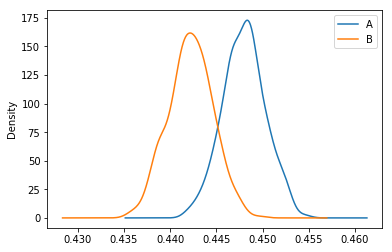

In [124]:
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_list)

# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_1d["A"].plot(kind = "kde", label = "A")
ax = boot_1d["B"].plot(kind = "kde", label = "B")
ax.legend()

We see clear peak difference in distrinbution of the two groups.    
However, we also see the overwrapping area, which means 1-day retention of Group A might be lower than Group B.    
Here we can calculate how many times out of 500 times re-sample, Group A's 1-day retention is higher than Group B.

In [125]:
# Adding a column with the % difference between the two AB-groups
boot_1d["diff"] = (boot_1d["A"]-boot_1d["B"])/boot_1d["B"]*100

boot_1d.head()

ab,A,B,diff
retention_1,0.446562,0.439814,1.534251
retention_1,0.451233,0.445502,1.286412
retention_1,0.445984,0.444931,0.236663
retention_1,0.448438,0.438733,2.212039
retention_1,0.444851,0.444990,-0.031171


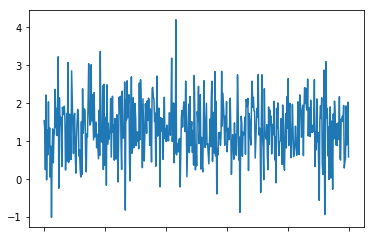

In [126]:
# Ploting the bootstrap % difference
ax = boot_1d["diff"].plot()

Looks like most of the time difference is around 1%-2%, but some times lower than 0, which means Group A has lower 1-day retention.    
Here is probability that Group A's 1-day retention is greater than Group B.

In [129]:
print((boot_1d["diff"]>0).mean())

0.964


So, we can say when the gate is moved to level 40, 1-day retention will probably get worse.

## 7-day retention

We can do the exactly same thing with 7-day retension and see what will happen when the gate is moved.

In [132]:
df.retention_7.sum()/df.retention_7.count()

0.1860648194347426

In [133]:
df.groupby("ab").retention_7.mean()

ab
A    0.190201
B    0.182000
Name: retention_7, dtype: float64

Overall, 7-day retention is much lower, meaning less people are playing the game after 1 week.    
Also, like 1-day retention, we see Group B's 7-day retention is lower than Group A.    
As before, let's use "Bootstrapping" to figure out how certain we should be of the difference between the AB-groups.

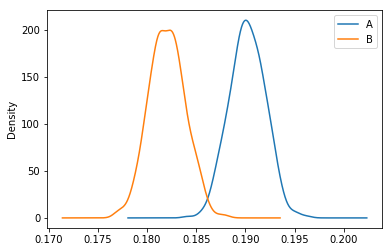

In [134]:
# Creating an empty list with bootstrapped means for each AB-group
boot_list = []

# Re-sample 500 times and store the 7-day retention in boot_list
for i in range(0,500):
    boot_mean = df.sample(frac = 1, replace = True).groupby("ab").retention_7.mean()
    boot_list.append(boot_mean)

# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_list)

# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_7d["A"].plot(kind = "kde", label = "A")
ax = boot_7d["B"].plot(kind = "kde", label = "B")
ax.legend()

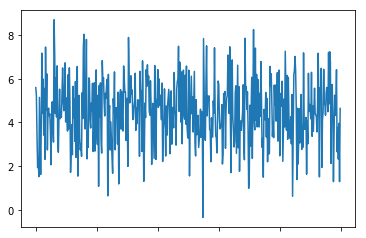

In [135]:
# Adding a column with the % difference between the two AB-groups
boot_7d["diff"] = (boot_7d["A"]-boot_7d["B"])/boot_7d["B"]*100

# Ploting the bootstrap % difference
ax = boot_7d["diff"].plot()

In [136]:
print((boot_7d["diff"]>0).mean())

0.998


So again, we can say when the gate is moved to level 40, 7-day retention will probably get worse.

## Conclusion

These analyses show strong evidence that both 1-day and 7-day retention will go down if the gate is moved to level 40.    　

So, if we want to keep retention high, we should not move the gate from level 30 to level 40.